In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Load data
data = pd.read_csv('original_data.csv')

# Prepare data for clustering
X = data[['Tot_Benes_standard_normal_variate', 'Tot_Srvcs_standard_normal_variate', 'Avg_Mdcr_Stdzd_Amt_standard_normal_variate']]

# Standardize the features (important for DBSCAN)
X_scaled = StandardScaler().fit_transform(X)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples based on your dataset characteristics
labels = dbscan.fit_predict(X_scaled)

# Identify points which form the core of a cluster
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Mark non-core points (considered as outliers in DBSCAN) in the original data
data['Far_Point'] = ~core_samples_mask

def inject_extreme_values(data, columns, fraction=0.05, multiplier=100):
    poisoned_data = data.copy()
    num_rows = len(data)
    num_extreme = int(num_rows * fraction)
    
    for col in columns:
        # Determine the range for extreme values
        extreme_value_high = data[col].mean() + data[col].std() * multiplier
        extreme_value_low = data[col].mean() - data[col].std() * multiplier

        # Select indices for high extremes
        indices_high = np.random.choice(data.index, size=num_extreme // 2, replace=False)
        # Inject high extreme values
        poisoned_data.loc[indices_high, col] = extreme_value_high

        # Select indices for low extremes
        indices_low = np.random.choice(data.index, size=num_extreme - (num_extreme // 2), replace=False)
        # Inject low extreme values
        poisoned_data.loc[indices_low, col] = extreme_value_low
        
    return poisoned_data

# Specify the columns to inject extreme values into
columns_to_convert = ['Tot_Benes_standard_normal_variate', 'Tot_Srvcs_standard_normal_variate', 'Avg_Mdcr_Stdzd_Amt_standard_normal_variate']

# Inject extreme values into the specified columns
extreme_values_data = inject_extreme_values(data, columns_to_convert)

print(extreme_values_data.head())
extreme_values_data.to_csv('extreme_data_with_outliers_0.05_multiplier_100.csv', index=False)

   Tot_Benes  Tot_Srvcs  Avg_Mdcr_Stdzd_Amt  \
0         28       32.0              581.89   
1         29       38.0              771.93   
2         11       12.0              562.18   
3         13       22.0              117.75   
4         12       16.0              588.58   

   Tot_Benes_standard_normal_variate  Tot_Srvcs_standard_normal_variate  \
0                          -0.112141                          -0.211364   
1                          -0.083824                          -0.108504   
2                          -0.593523                          -0.554231   
3                          -0.536889                          -0.382798   
4                          -0.565206                          -0.485658   

   Avg_Mdcr_Stdzd_Amt_standard_normal_variate  Far_Point  
0                                   -0.124550      False  
1                                    1.229521      False  
2                                   -0.264987      False  
3                             

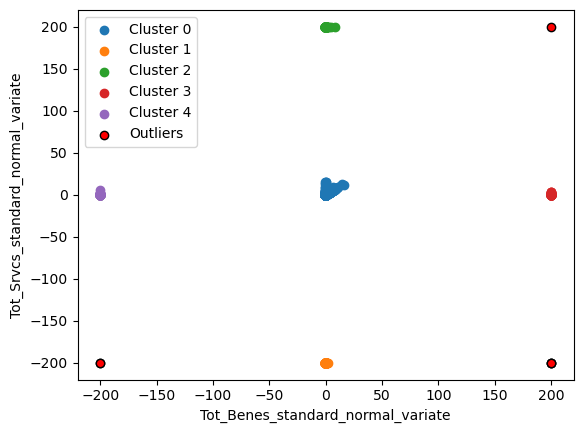

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Assuming extreme_values_data is your DataFrame after running the previous operations
extreme_values_data = pd.read_csv('extreme_data_with_outliers_0.05_multiplier_200.csv')

# Prepare data for clustering
X = extreme_values_data[['Tot_Benes_standard_normal_variate', 'Tot_Srvcs_standard_normal_variate']]

# Standardize features for DBSCAN
X_scaled = StandardScaler().fit_transform(X)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # You might need to adjust these parameters
labels = dbscan.fit_predict(X_scaled)
extreme_values_data['Cluster'] = labels

# Determine outliers (DBSCAN labels outliers as -1)
extreme_values_data['Is_Outlier'] = (extreme_values_data['Cluster'] == -1)

# Plotting 2D scatter plot
plt.figure()

# Plot non-outliers
unique_clusters = set(labels) - {-1}  # Exclude the outlier label which is -1
for cluster_id in unique_clusters:
    cluster_data = extreme_values_data[extreme_values_data['Cluster'] == cluster_id]
    plt.scatter(cluster_data['Tot_Benes_standard_normal_variate'], 
                cluster_data['Tot_Srvcs_standard_normal_variate'], 
                label=f'Cluster {cluster_id}')

# Plot outliers
outliers = extreme_values_data[extreme_values_data['Is_Outlier']]
plt.scatter(outliers['Tot_Benes_standard_normal_variate'], 
            outliers['Tot_Srvcs_standard_normal_variate'], 
            c='red', label='Outliers', edgecolors='black')

# Set the labels for each axis
plt.xlabel('Tot_Benes_standard_normal_variate')
plt.ylabel('Tot_Srvcs_standard_normal_variate')

# Create a legend
plt.legend()

# Show the plot
plt.show()